# Setup

In [57]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import itertools
import tensorflow as tf

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')


from tensorflow import keras
from kerastuner.tuners import RandomSearch


In [58]:
def reshape(img):
    img = cv2.resize(img, (28, 28))
    return img

def readimage(path):
    return cv2.imread(path, 0)

def visualize(img):
    plt.imshow(img)



In [59]:
path = "/kaggle/input/amharic-characters-datasets/augmented_images"
data = []
for root, dirs, files in os.walk(path):
    if files:
        for file in files:
            image = reshape(readimage(os.path.join(root, file))).reshape(784)
            image = np.append(image, int(root.split('/')[-1])-1)
            data.append(image)
            
dataset = pd.concat([pd.DataFrame(data)])


# Load the dataset

In [130]:

dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6


In [131]:
dataset.shape

(5910, 785)

In [132]:
dataset[784].value_counts()

0      70
22     55
7      55
21     55
6      50
       ..
184    25
78     25
194    25
155    25
135    25
Name: 784, Length: 202, dtype: int64

# Visualize the Data

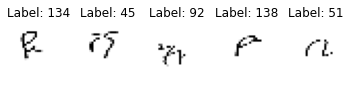

In [133]:

# Assuming X_train and y_train are your image and label data
for i in range(5):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, ith position
    im = X_train[i].reshape(28, 28)
    plt.imshow(im, cmap='gray')  # assuming grayscale images
    plt.title(f"Label: {y_train.iloc[i]}")
    plt.axis('off')

plt.show()


# Stratified Shuffling

In [134]:

splited = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splited.split(dataset, dataset[784]):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]
    


In [135]:
from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to your training data
scaler.fit_transform(train_set)

# apply the scaler to your training and testing data
scaler.transform(test_set)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.45314757],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.14611413],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.88755967],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.38661039],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.79494294],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.26167435]])

In [136]:
train_set.shape

(5319, 785)

In [137]:
test_set.shape

(591, 785)

# Split the dataset into train and test

In [138]:
X_train, y_train, X_test, y_test = train_set.loc[:, train_set.columns != 784], train_set[784], test_set.loc[:, test_set.columns != 784], test_set[784]


In [71]:
X_train.shape
y_train.shape

(5319,)

In [139]:
y_test.value_counts()

0      7
21     6
5      5
28     5
3      5
      ..
172    2
182    2
112    2
145    2
104    2
Name: 784, Length: 202, dtype: int64

In [140]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Model Training

In [74]:
!pip install keras-tuner


In [92]:
# Define the model-building function
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Int('conv4_filters', min_value=64, max_value=256, step=64),
                     kernel_size=(3, 3),
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(202, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [105]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)


# Data augmentation 

In [107]:

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

datagen.fit(X_train)

# hyperparameter tuning

In [108]:
# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can adjust the number of trials
    directory='tuner_logs',  # Specify a directory to save logs and results
    project_name='my_tuning')

# Perform hyperparameter tuning
tuner.search(datagen.flow(X_train, Y_train, batch_size=128),
             epochs=10,
             validation_data=(X_test, Y_test),
             steps_per_epoch=X_train.shape[0] // 128)

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.7191201448440552

Best val_accuracy So Far: 0.7664974331855774
Total elapsed time: 00h 01m 45s
Best Hyperparameters:
{'conv1_filters': 32, 'conv2_filters': 64, 'dropout_1': 0.30000000000000004, 'conv3_filters': 192, 'conv4_filters': 128, 'dropout_2': 0.30000000000000004, 'dense_units': 256, 'dropout_3': 0.4000000000000001}


In [109]:
Y_train = to_categorical(y_train, num_classes = 202, dtype='int')
print("New shape of train labels: ", Y_train.shape)

Y_test = to_categorical(y_test, num_classes = 202, dtype='int')
print("New shape of test labels: ", Y_test.shape)

New shape of train labels:  (5319, 202)
New shape of test labels:  (591, 202)


# Fit the model

In [110]:
# Fit the best model on the entire dataset
best_model.fit(X_train, Y_train, epochs=2, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/2
42/42 [==============================] - 2s 28ms/step - loss: 0.8373 - accuracy: 0.8064 - val_loss: 3.0175 - val_accuracy: 0.2572
Epoch 2/2
42/42 [==============================] - 1s 21ms/step - loss: 0.6325 - accuracy: 0.8567 - val_loss: 1.7994 - val_accuracy: 0.5042


# Plot the loss and accuracy curves for training and validation 

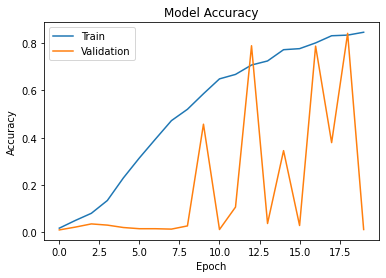

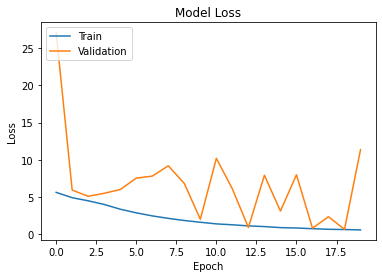

In [112]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the result of model.fit()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Confusion Matrix 

In [113]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Save Model

In [114]:
model.summary()
model.save(r'cnn1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       7

# Classes

In [115]:
word_dict = {i: str(i) for i in range(202)}


(28, 28)
50


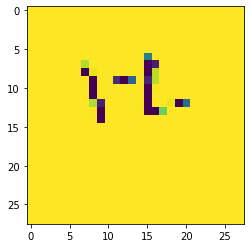

In [126]:
im = X_test[25].reshape(28, 28)
print(im.shape)
plt.imshow(im)
plt.savefig("cnnimage.png")
print(y_train.iloc[25])

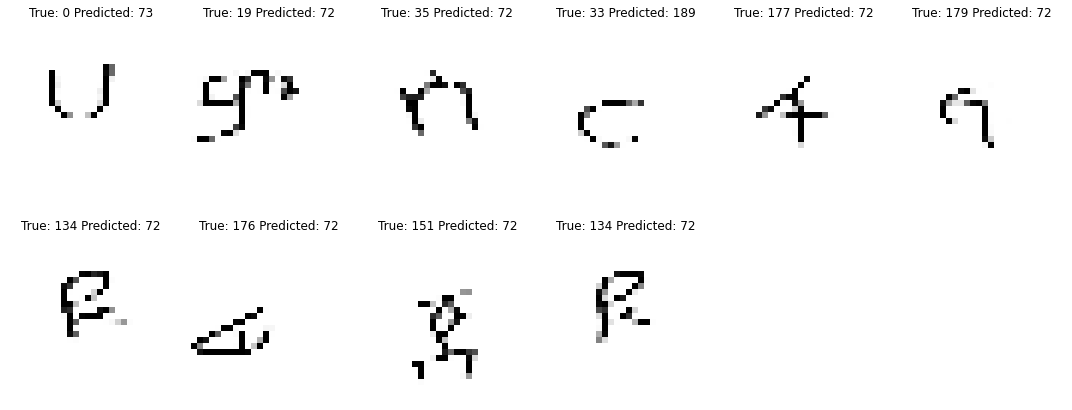

In [125]:
plt.figure(figsize=(15,15))
for i in range(10):
    img = np.reshape(X_test[i], (28,28))
    plt.subplot(5, 6, i+1)
    plt.imshow(img,cmap="gray")
    img_final =np.reshape(img, (-1,28,28,1))
    pred_prob = model.predict(img_final)
    pred = word_dict[np.argmax(pred_prob)]
    plt.title(f'True: {y_test.iloc[i]} Predicted: {pred}')
    plt.axis('off')
plt.tight_layout()
plt.show()
